
# **DETECTING BREAST CANCER ON ULTRASOUND DATASET**





---

# **DOWNLOAD THE KAGGLE DATSET**

> Implementation by Prajwal

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

100%|██████████| 195M/195M [00:04<00:00, 44.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1


In [ ]:
!mv /root/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1 /content/breast-ultrasound-images-dataset


# **IMPORT MODULES**

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import warnings
warnings.filterwarnings("ignore")

# **SET DATA PATH**

In [ ]:
data = '/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

In [ ]:
from pathlib import Path
import pandas as pd
import os

# Define the directory containing images
data = '/content/breast-ultrasound-images-dataset'  # Update this path as per your dataset location
image_dir = Path(data)

# Get file paths for both .PNG and .png files
filepaths = list(image_dir.glob('**/*.PNG')) + list(image_dir.glob('**/*.png'))

# Extract labels based on the folder names
labels = list(map(lambda x: os.path.basename(os.path.dirname(x)), filepaths))

# Create pandas Series for filepaths and labels
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Combine into a DataFrame
image_df = pd.concat([filepaths, labels], axis=1)

# Display the DataFrame
print(image_df.head())


                                            Filepath   Label
0  /content/breast-ultrasound-images-dataset/Data...  normal
1  /content/breast-ultrasound-images-dataset/Data...  normal
2  /content/breast-ultrasound-images-dataset/Data...  normal
3  /content/breast-ultrasound-images-dataset/Data...  normal
4  /content/breast-ultrasound-images-dataset/Data...  normal


In [ ]:
labels

,Label
0,normal
1,normal
2,normal
3,normal
4,normal
...,...
1573,benign
1574,benign
1575,benign
1576,benign


In [ ]:
filepaths

,Filepath
0,/content/breast-ultrasound-images-dataset/Data...
1,/content/breast-ultrasound-images-dataset/Data...
2,/content/breast-ultrasound-images-dataset/Data...
3,/content/breast-ultrasound-images-dataset/Data...
4,/content/breast-ultrasound-images-dataset/Data...
...,...
1573,/content/breast-ultrasound-images-dataset/Data...
1574,/content/breast-ultrasound-images-dataset/Data...
1575,/content/breast-ultrasound-images-dataset/Data...
1576,/content/breast-ultrasound-images-dataset/Data...


# **DISPLAY FEW IMAGES { EDA }**

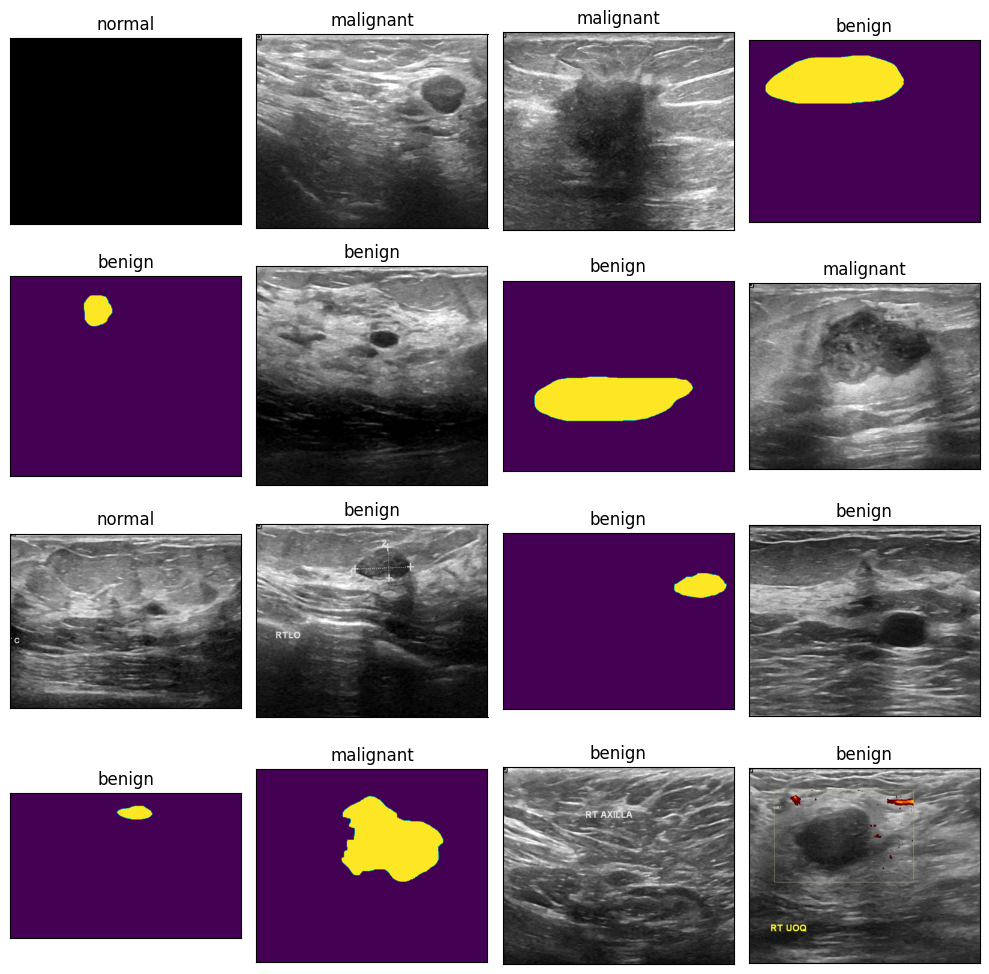

In [ ]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# **AGUMENTATION**

In [ ]:
IMAGE_SHAPE = (224, 224)

def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

# **NUMBER OF IMAGES**

In [ ]:
import os
import glob

# Define the path to the dataset
data = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'  # Update this path to match your dataset location

# Get a list of all directories (folders) within the dataset
directories = os.listdir(data)

# Initialize lists to store file paths and corresponding labels
files = []
labels = []

# Read files from each directory
for folder in directories:
    # Use glob to find all files within each folder
    fileList = glob.glob(os.path.join(data, folder, '*'))

    # Add the folder name as a label for each file found
    labels.extend([folder] * len(fileList))
    files.extend(fileList)

# Output the total number of files and labels collected
print(len(files), len(labels))


1578 1578


In [ ]:
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)


len(selected_files), len(selected_labels)

(780, 780)

In [ ]:
# the dictionary holds list of images and for each one has its target/label
images = {
    'image': [],
    'target': []
}

for i, (file, label) in enumerate(zip(selected_files, selected_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

print('Finished.')

Finished.


# ***LABEL THE CLASSES***

In [ ]:
# convert lists to arrays
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


# ***train_test_split***

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((702, 224, 224, 3), (78, 224, 224, 3), (702,), (78,))

## **DEFINE THE MODEL HERE :**

In [ ]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
# incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

incept_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

incept_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 16,201,987 (61.81 MB)

 Trainable params: 1,486,339 (5.67 MB)

 Non-trainable params: 14,715,648 (56.14 MB)

# **RUN THE MODEL**

In [ ]:
history = incept_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=20)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 432s 20s/step - accuracy: 0.4803 - loss: 1.0731 - val_accuracy: 0.4872 - val_loss: 0.9861
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 439s 19s/step - accuracy: 0.7037 - loss: 0.7339 - val_accuracy: 0.6795 - val_loss: 0.8689
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 421s 19s/step - accuracy: 0.8339 - loss: 0.5122 - val_accuracy: 0.7051 - val_loss: 0.8436
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 488s 21s/step - accuracy: 0.8764 - loss: 0.3963 - val_accuracy: 0.7051 - val_loss: 0.8084
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 462s 21s/step - accuracy: 0.9106 - loss: 0.3037 - val_accuracy: 0.7179 - val_loss: 0.7610
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 465s 19s/step - accuracy: 0.9327 - loss: 0.2506 - val_accuracy: 0.7179 - val_loss: 0.7110
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 427s 20s/step - accuracy: 0.9404 - loss: 0.1995 - val_accuracy: 0.6923 - val_loss: 0.7195
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 428s 19s/step - accuracy: 0.9625 - loss: 0.1619 - val_accuracy: 0.

# **TRAINING ANALYSIS**

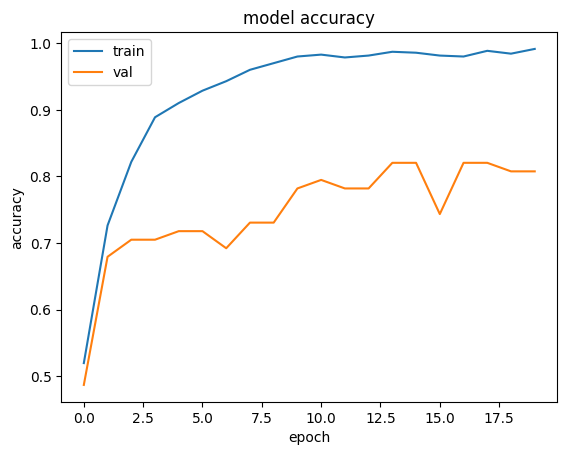

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **PREDICT THE IMAGE BY MODEL**

In [ ]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = incept_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

# **save and download the model**

In [ ]:
# Saving the model
incept_model.save('breast_detect.h5')

# Downloading the model
from google.colab import files
files.download('breast_detect.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>